=== Minimum Scoring Combination ===
Weights: [2.55715979e-02 9.74428402e-01 1.46925162e-17]
Total Score: 0.5287
Violation Rate: 0.0515


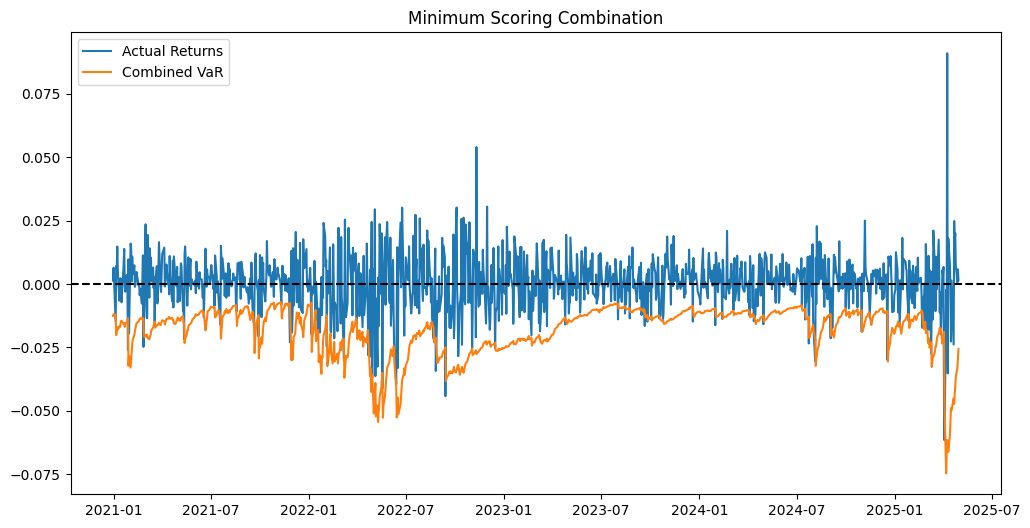


=== Relative Scoring Combination ===
Weights: GARCH        0.333033
GJR-GARCH    0.336008
iGARCH       0.330959
dtype: float64
Total Score: 0.5372
Violation Rate: 0.0506


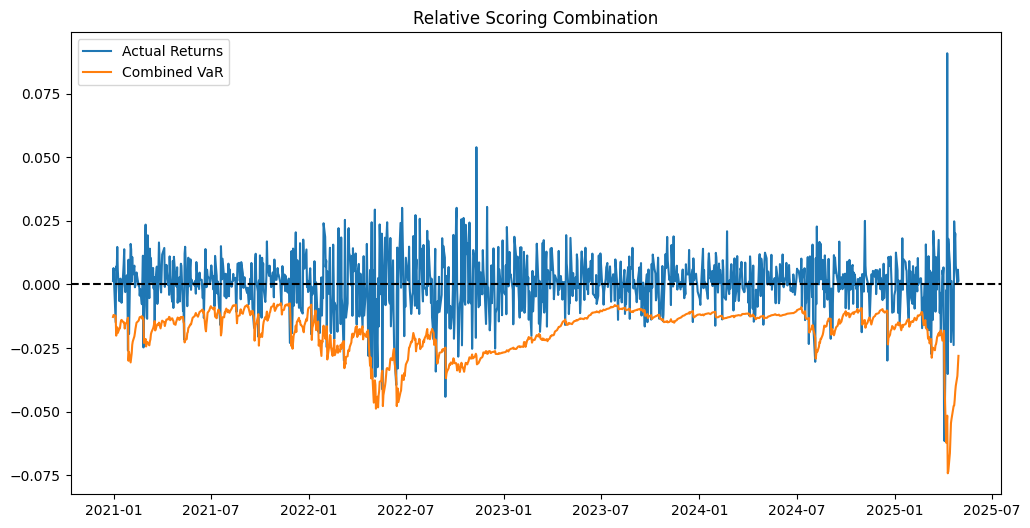


=== Summary Comparison ===
MSC score: 0.5287, RSC score: 0.5372
MSC violations: 5.1471%, RSC violations: 5.0551%
→ RSC closer to target violation rate.
→ MSC has lower (better) total score.
=== Individual Model Evaluation ===
Model: GARCH
VaR: [-0.01257247 -0.0117932  -0.01215084 ... -0.03869334 -0.0345083
 -0.03047421]
Model: GARCH
  Total Score: 0.5465
  Violation Rate: 5.4228%
Model: GJR-GARCH
VaR: [-0.01258441 -0.01197012 -0.01210989 ... -0.03285259 -0.02928279
 -0.02553571]
Model: GJR-GARCH
  Total Score: 0.5288
  Violation Rate: 5.2390%
Model: iGARCH
VaR: [-0.01321661 -0.01230721 -0.01266753 ... -0.03646953 -0.03233638
 -0.02829915]
Model: iGARCH
  Total Score: 0.5590
  Violation Rate: 5.3309%


/Users/liuliangjie/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Failed to get ticker '^IRX' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['^IRX']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')



=== Statistical Comparison: MSC vs RSC ===
MSC Mean: nan, Variance: nan
RSC Mean: nan, Variance: nan
F-test (Variance Equality): F = nan, p = nan
t-test (Mean Equality):     t = nan, p = nan


In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

class VaRCombiner:
    def __init__(self, pred_df, actual_returns, alpha=0.01):
        """
        pred_df: DataFrame, columns are model names, index is date, values are VaR predictions
        actual_returns: Series, index is date, values are actual returns
        alpha: VaR confidence level (default is 0.01 for 99% VaR)
        """
        self.pred_df = pred_df
        self.actual_returns = actual_returns
        self.alpha = alpha

    def scoring_function(self, VaR, ret):
        indicator = (ret <= VaR).astype(int)
        return (self.alpha - indicator) * (ret - VaR)

    def total_score(self, weights):
        combined_VaR = np.dot(self.pred_df.values, weights)
        score = self.scoring_function(combined_VaR, self.actual_returns.values)
        return np.sum(score)

    def minimum_scoring_combination(self):
        n_models = self.pred_df.shape[1]
        init_weights = np.ones(n_models) / n_models

        cons = ({
            'type': 'eq',
            'fun': lambda w: np.sum(w) - 1
        })

        bounds = [(0, 1) for _ in range(n_models)]

        result = minimize(self.total_score, init_weights, bounds=bounds, constraints=cons)

        return result.x, np.dot(self.pred_df.values, result.x)

    def relative_scoring_combination(self):
        scores = self.scoring_function(self.pred_df, self.actual_returns.values.reshape(-1, 1))
        total_scores = np.sum(scores, axis=0)

        delta_scores = total_scores - np.min(total_scores)
        weights = np.exp(-0.5 * delta_scores) / np.sum(np.exp(-0.5 * delta_scores))

        combined_VaR = np.dot(self.pred_df.values, weights)
        return weights, combined_VaR

    def plot_combined_VaR(self, combined_VaR, title="Combined VaR vs Actual Returns"):
        plt.figure(figsize=(12, 6))
        plt.plot(self.actual_returns.index, self.actual_returns.values, label="Actual Returns")
        plt.plot(self.actual_returns.index, combined_VaR, label="Combined VaR")
        plt.axhline(0, color='black', linestyle='--')
        plt.legend()
        plt.title(title)
        plt.show()

    def calculate_total_score(self, combined_VaR):
        score = self.scoring_function(combined_VaR, self.actual_returns.values)
        return np.sum(score)

    def calculate_VaR_violations(self, combined_VaR):
        """
        计算VaR违约率，即实际收益低于或等于VaR的比例（发生违约）
        """
        violations = (self.actual_returns.values < combined_VaR).sum()
        return violations / len(self.actual_returns)

    def compare_methods(self, plot=True):
        """
        比较 Minimum Scoring Combination 和 Relative Scoring Combination 的表现
        包括：得分总和、违约率、可选作图展示
        """
        print("=== Minimum Scoring Combination ===")
        min_weights, min_combined_VaR = self.minimum_scoring_combination()
        min_score = self.calculate_total_score(min_combined_VaR)
        min_viol = self.calculate_VaR_violations(min_combined_VaR)
        print("Weights:", min_weights)
        print("Total Score:", round(min_score, 4))
        print("Violation Rate:", round(min_viol, 4))
        if plot:
            self.plot_combined_VaR(min_combined_VaR, title="Minimum Scoring Combination")

        print("\n=== Relative Scoring Combination ===")
        rel_weights, rel_combined_VaR = self.relative_scoring_combination()
        rel_score = self.calculate_total_score(rel_combined_VaR)
        rel_viol = self.calculate_VaR_violations(rel_combined_VaR)
        print("Weights:", rel_weights)
        print("Total Score:", round(rel_score, 4))
        print("Violation Rate:", round(rel_viol, 4))
        if plot:
            self.plot_combined_VaR(rel_combined_VaR, title="Relative Scoring Combination")

        print("\n=== Summary Comparison ===")
        print(f"MSC score: {min_score:.4f}, RSC score: {rel_score:.4f}")
        print(f"MSC violations: {min_viol:.4%}, RSC violations: {rel_viol:.4%}")
        if abs(min_viol - self.alpha) < abs(rel_viol - self.alpha):
            print("→ MSC closer to target violation rate.")
        else:
            print("→ RSC closer to target violation rate.")
        if min_score < rel_score:
            print("→ MSC has lower (better) total score.")
        else:
            print("→ RSC has lower (better) total score.")
        
    def evaluate_individual_models(self):
        """
        输出每个单独VaR模型的违约率与总得分
        """
        print("=== Individual Model Evaluation ===")
        for col in self.pred_df.columns:
            model_VaR = self.pred_df[col].values
            print(f"Model: {col}")
            print(f"VaR: {model_VaR}")
            score = np.sum(self.scoring_function(model_VaR, self.actual_returns.values))
            violations = (self.actual_returns.values < model_VaR).sum() / len(self.actual_returns)
            print(f"Model: {col}")
            print(f"  Total Score: {score:.4f}")
            print(f"  Violation Rate: {violations:.4%}")
        
    def rolling_msr_series(self, combined_VaR, risk_free_rate=0.0):
        """
        返回逐期的 mSR_t = (r_t - rf_t) / |VaR_t|，可用于分阶段统计分析
        """
        if isinstance(risk_free_rate, (int, float)):
            excess = self.actual_returns.values - risk_free_rate
        else:
            # pandas Series 输入：需对齐索引
            excess = self.actual_returns.values - risk_free_rate.reindex(self.actual_returns.index).values.flatten()
        msr_series = excess / np.abs(combined_VaR)
        return pd.Series(msr_series, index=self.actual_returns.index)


from scipy.stats import ttest_ind, levene

def compare_msr_statistics(msr1, msr2, label1="Model 1", label2="Model 2"):
    """
    比较两个 mSR 序列的均值、方差、t检验、F检验
    """
    print(f"\n=== Statistical Comparison: {label1} vs {label2} ===")
    print(f"{label1} Mean: {msr1.mean():.4f}, Variance: {msr1.var():.4f}")
    print(f"{label2} Mean: {msr2.mean():.4f}, Variance: {msr2.var():.4f}")
    
    f_stat, f_p = levene(msr1, msr2)
    t_stat, t_p = ttest_ind(msr1, msr2, equal_var=False)
    
    print(f"F-test (Variance Equality): F = {f_stat:.4f}, p = {f_p:.4f}")
    print(f"t-test (Mean Equality):     t = {t_stat:.4f}, p = {t_p:.4f}")


if __name__ == "__main__":
    pred_df_AR = pd.read_csv("Data/GARCH-AR-0-VaR.csv", index_col="Date", parse_dates=True)
    pred_df_Const = pd.read_csv("Data/GARCH-AR-1-VaR.csv", index_col="Date", parse_dates=True)
    pred_df_iGARCH = pd.read_csv("Data/iGARCH-VaR.csv", index_col="Date", parse_dates=True)
    
    actual_returns = pd.read_csv("Data/GARCH-Constant-actual.csv", index_col="Date", parse_dates=True)

    irx = yf.download("^IRX", start="2020-01-01", end="2025-01-01", auto_adjust=True)["Close"]
    rf_daily = (irx / 252).reindex(actual_returns.index).ffill()

    msr_msc_dict = {}
    msr_rsc_dict = {}

    for index in ["^GSPC","GLD","USO","GLD-USO"]:
        pred_df = pd.concat([pred_df_AR[index], pred_df_Const[index], pred_df_iGARCH[index]], axis=1, join='inner')
        pred_df.columns = ["GARCH", "GJR-GARCH", "iGARCH"]

        combiner = VaRCombiner(pred_df, actual_returns[index])
        combiner.compare_methods()
        combiner.evaluate_individual_models()

        min_weights, min_combined_VaR = combiner.minimum_scoring_combination()
        rel_weights, rel_combined_VaR = combiner.relative_scoring_combination()

        msr_msc_dict[index] = combiner.rolling_msr_series(min_combined_VaR, risk_free_rate=rf_daily)
        msr_rsc_dict[index] = combiner.rolling_msr_series(rel_combined_VaR, risk_free_rate=rf_daily)

    # 比较每个资产的 MSC 与 RSC 的 mSR
    msr_dict = msr_msc_dict  # ← 如果你想用 RSC，就改成 msr_rsc_dict

    # 提取均值与标准差
    summary_stats = {
        asset: {
            "mean": msr.mean(),
            "std": msr.std()
        } for asset, msr in msr_dict.items()
    }

    # 转为 DataFrame
    summary_df = pd.DataFrame(summary_stats).T
    summary_df = summary_df[["mean", "std"]]
    summary_df.columns = ["Mean_mSR", "Std_mSR"]
    print(summary_df)

    # 可视化：条形图（含标准差误差条）
    plt.figure(figsize=(8, 5))
    plt.bar(summary_df.index, summary_df["Mean_mSR"], yerr=summary_df["Std_mSR"], capsize=5)
    plt.title("Mean mSR under MSC with Std Error Bars")
    plt.ylabel("Mean mSR")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

In [2]:
min_combined_VaR.shape

(1088,)

In [3]:
rf_daily.shape

(1088, 1)

In [4]:
%pip install pandas


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
